# Sentiment Analysis 


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
print("Downloading NLTK data...")

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load the datasets
def load_dataset(file_path, source_name):
    """Load dataset from file and add source column"""
    df = pd.read_csv(file_path, sep='\t', header=None, names=['text', 'sentiment'])
    df['source'] = source_name
    return df

# Load all three datasets
amazon_df = load_dataset('sentiment+labelled+sentences (1)/sentiment labelled sentences/amazon_cells_labelled.txt', 'Amazon')
imdb_df = load_dataset('sentiment+labelled+sentences (1)/sentiment labelled sentences/imdb_labelled.txt', 'IMDB')
yelp_df = load_dataset('sentiment+labelled+sentences (1)/sentiment labelled sentences/yelp_labelled.txt', 'Yelp')

# Combine all datasets
combined_df = pd.concat([amazon_df, imdb_df, yelp_df], ignore_index=True)

print(f"Total dataset size: {len(combined_df)} samples")
print(f"Amazon samples: {len(amazon_df)}")
print(f"IMDB samples: {len(imdb_df)}")
print(f"Yelp samples: {len(yelp_df)}")

# Display basic information
print("\nDataset Info:")
print(combined_df.info())
print("\nFirst few samples:")
display(combined_df.head())

Total dataset size: 2748 samples
Amazon samples: 1000
IMDB samples: 748
Yelp samples: 1000

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2748 non-null   object
 1   sentiment  2748 non-null   int64 
 2   source     2748 non-null   object
dtypes: int64(1), object(2)
memory usage: 64.5+ KB
None

First few samples:


,text,sentiment,source
0,So there is no way for me to plug it in here i...,0,Amazon
1,"Good case, Excellent value.",1,Amazon
2,Great for the jawbone.,1,Amazon
3,Tied to charger for conversations lasting more...,0,Amazon
4,The mic is great.,1,Amazon


Class Distribution:
sentiment
1    1386
0    1362
Name: count, dtype: int64



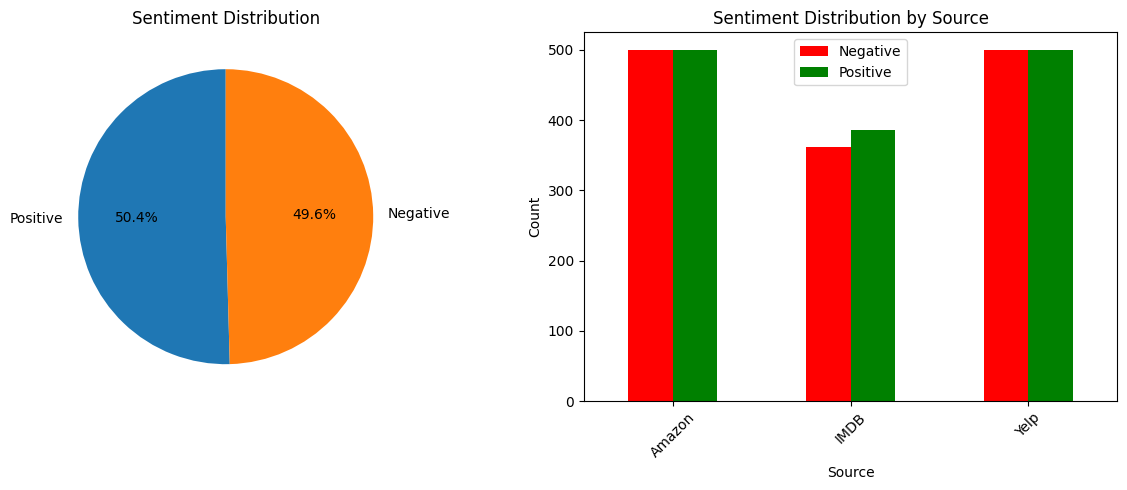

In [4]:
# Dataset Statistics and Distribution Analysis
# Check class balance
print("Class Distribution:")
print(combined_df['sentiment'].value_counts())
print()

# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Sentiment distribution pie chart
sentiment_counts = combined_df['sentiment'].value_counts()
axes[0].pie(sentiment_counts.values, labels=['Positive', 'Negative'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Sentiment Distribution')

# Sentiment distribution by source
source_sentiment = pd.crosstab(combined_df['source'], combined_df['sentiment'])
source_sentiment.plot(kind='bar', ax=axes[1], color=['red', 'green'])
axes[1].set_title('Sentiment Distribution by Source')
axes[1].set_xlabel('Source')
axes[1].set_ylabel('Count')
axes[1].legend(['Negative', 'Positive'])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

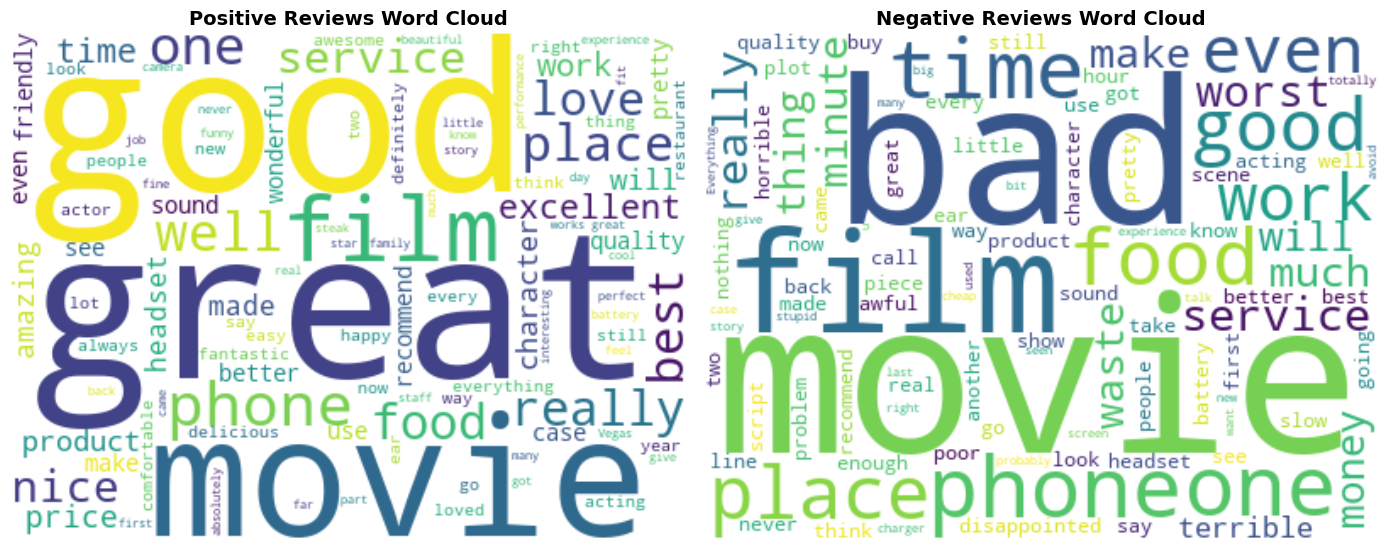

In [5]:
# Word Cloud Generation
positive_texts = combined_df[combined_df['sentiment'] == 1]['text'].tolist()
negative_texts = combined_df[combined_df['sentiment'] == 0]['text'].tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Positive sentiment word cloud
pos_text = ' '.join(positive_texts)
wordcloud_pos = WordCloud(width=400, height=300, background_color='white', 
                          max_words=100).generate(pos_text)
ax1.imshow(wordcloud_pos, interpolation='bilinear')
ax1.set_title('Positive Reviews Word Cloud', fontsize=14, fontweight='bold')
ax1.axis('off')

# Negative sentiment word cloud
neg_text = ' '.join(negative_texts)
wordcloud_neg = WordCloud(width=400, height=300, background_color='white', 
                          max_words=100).generate(neg_text)
ax2.imshow(wordcloud_neg, interpolation='bilinear')
ax2.set_title('Negative Reviews Word Cloud', fontsize=14, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

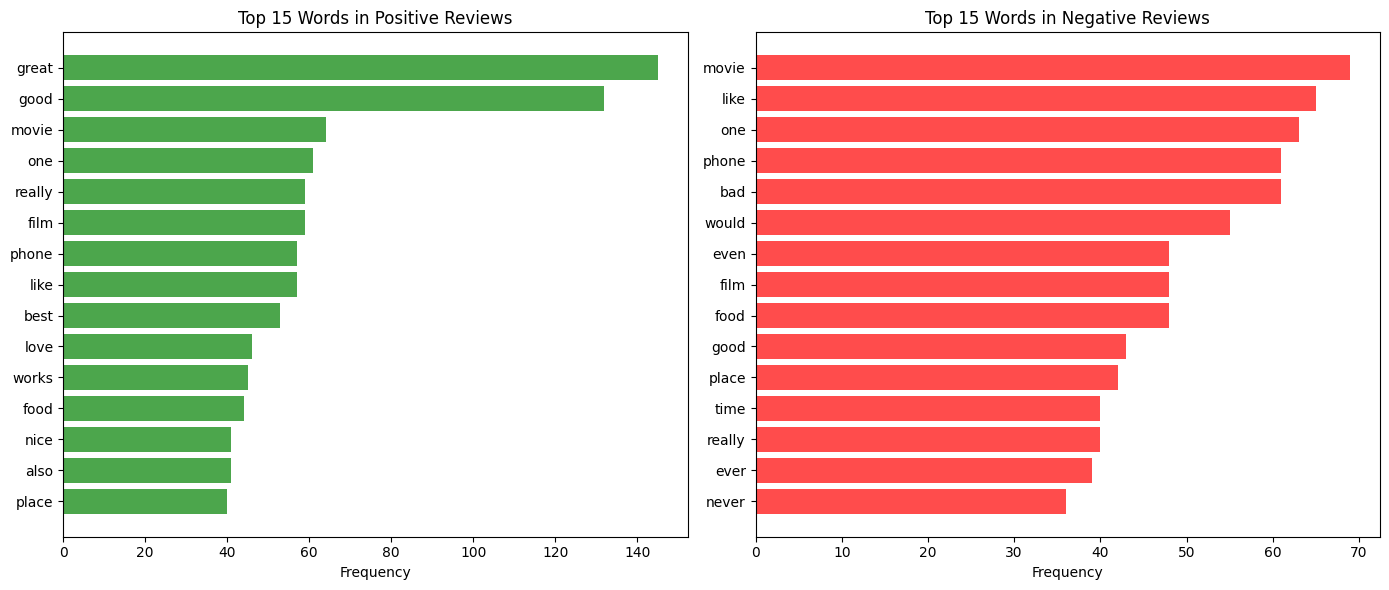

In [6]:
# Simple word frequency analysis
from collections import Counter

stop_words = set(stopwords.words('english'))

# Get all words from positive and negative reviews
positive_texts = combined_df[combined_df['sentiment'] == 1]['text'].tolist()
negative_texts = combined_df[combined_df['sentiment'] == 0]['text'].tolist()

# Simple word counting
pos_words = []
for text in positive_texts:
    words = [word.lower() for word in text.split() if word.isalpha() and len(word) > 2]
    pos_words.extend([w for w in words if w not in stop_words])

neg_words = []
for text in negative_texts:
    words = [word.lower() for word in text.split() if word.isalpha() and len(word) > 2]
    neg_words.extend([w for w in words if w not in stop_words])

# Get top words
pos_freq = Counter(pos_words).most_common(15)
neg_freq = Counter(neg_words).most_common(15)

# Plot word frequencies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

pos_w, pos_c = zip(*pos_freq)
ax1.barh(range(len(pos_w)), pos_c, color='green', alpha=0.7)
ax1.set_yticks(range(len(pos_w)))
ax1.set_yticklabels(pos_w)
ax1.set_title('Top 15 Words in Positive Reviews')
ax1.set_xlabel('Frequency')
ax1.invert_yaxis()

neg_w, neg_c = zip(*neg_freq)
ax2.barh(range(len(neg_w)), neg_c, color='red', alpha=0.7)
ax2.set_yticks(range(len(neg_w)))
ax2.set_yticklabels(neg_w)
ax2.set_title('Top 15 Words in Negative Reviews')
ax2.set_xlabel('Frequency')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Data Preprocessing


In [7]:
# Text preprocessing function (following guide approach)
def preprocess_text(text):
    """Simple text preprocessing using tokenization, stopword removal, and stemming"""
    # Tokenize - using RegexpTokenizer to keep only alphanumeric characters and apostrophes
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
    tokens = tokenizer.tokenize(text)
    
    # Remove stopwords and convert to lowercase
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    
    # Apply stemming
    stemmer = PorterStemmer()
    stemmed_text = [stemmer.stem(word) for word in cleaned_tokens]
    
    return ' '.join(stemmed_text)

# Apply preprocessing
print("Applying text preprocessing...")
combined_df['text_cleaned'] = combined_df['text'].apply(preprocess_text)

# Show example of preprocessing
print("\nPreprocessing Examples:")
for i in range(3):
    print(f"\nOriginal: {combined_df.iloc[i]['text']}")
    print(f"Cleaned:  {combined_df.iloc[i]['text_cleaned']}")

print(f"\nPreprocessing completed! Dataset ready for modeling.")

Applying text preprocessing...

Preprocessing Examples:

Original: So there is no way for me to plug it in here in the US unless I go by a converter.
Cleaned:  way plug us unless go convert

Original: Good case, Excellent value.
Cleaned:  good case excel valu

Original: Great for the jawbone.
Cleaned:  great jawbon

Preprocessing completed! Dataset ready for modeling.


## Sentiment Analysis Implementation

In [8]:
# Prepare data for modeling
X = combined_df['text_cleaned']
y = combined_df['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training set sentiment distribution: {y_train.value_counts().to_dict()}")
print(f"Test set sentiment distribution: {y_test.value_counts().to_dict()}")

Training set size: 2198
Test set size: 550
Training set sentiment distribution: {1: 1109, 0: 1089}
Test set sentiment distribution: {1: 277, 0: 273}


In [9]:
# Feature Engineering - Term Frequency Matrix using CountVectorizer
vectorizer = CountVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print(f"Feature matrix shape: {X_train_vectorized.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

Feature matrix shape: (2198, 3477)
Vocabulary size: 3477


In [10]:
# Handle class imbalance using undersampling
resampler = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_vectorized, y_train)

# Check resampled distribution
print("Resampled class distribution:")
print(pd.Series(y_train_resampled).value_counts())

# Train Naive Bayes model
print("\nTraining Multinomial Naive Bayes classifier...")
model = MultinomialNB()
model.fit(X_train_resampled, y_train_resampled)

print("Model training completed!")

Resampled class distribution:
sentiment
0    1089
1    1089
Name: count, dtype: int64

Training Multinomial Naive Bayes classifier...
Model training completed!


In [11]:
# Model Evaluation
y_pred = model.predict(X_test_vectorized)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}\n")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Model Accuracy: 80.36%

Confusion Matrix:
[[218  55]
 [ 53 224]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.80      0.80       273
    Positive       0.80      0.81      0.81       277

    accuracy                           0.80       550
   macro avg       0.80      0.80      0.80       550
weighted avg       0.80      0.80      0.80       550



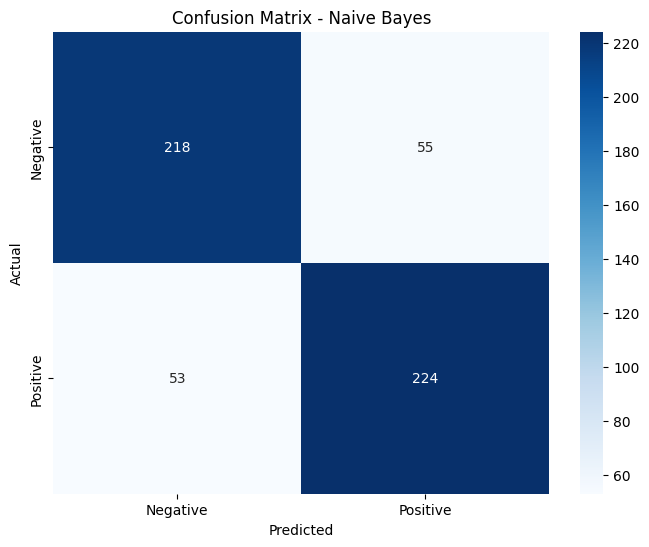

In [12]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()